In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: cpu


In [31]:
# hypter parameter setting
learning_rate = 1e-1
epochs = 10
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.Tanh()
h = 200

display_step = 10
dropout_rate = .2 # probability to be 0 

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


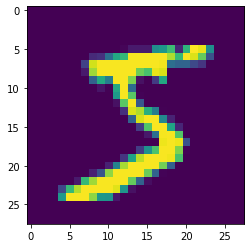

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([2, 6, 7, 0, 3, 3, 2, 7, 4, 7, 2, 0, 1, 1, 2, 4, 9, 8, 7, 2, 4, 0, 0, 7,
        5, 7, 8, 8, 1, 8, 8, 5])


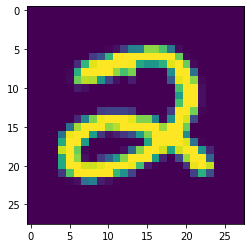

In [3]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

In [4]:
# model
model = nn.Sequential(
        nn.Linear(np.prod(x_train.shape[1:]),1024),
        act,
        nn.Linear(1024,300),
        act,
        nn.Linear(300,10)
        )

model = model.to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [5]:
loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1)
        y = label.to(device)
        
        output = model(x)

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        iteration_loss_array.append(loss.cpu().detach().numpy())
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 5 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

Epoch: 1 \Loss: tensor(0.0875, grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.0177, grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0215, grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0050, grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 26 \Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
total 10000
correct tensor(9810.)
accuracy tensor(0.9810)


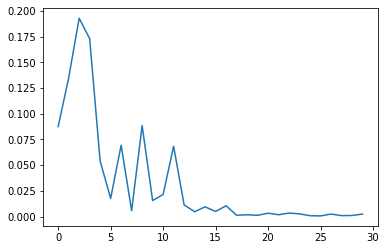

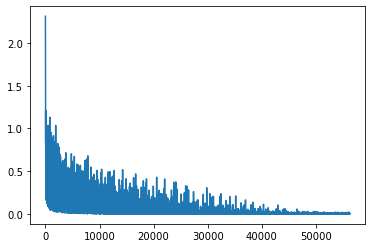

prediction : (10000,)
true label : (10000,)


array([[ 973,    0,    1,    1,    0,    0,    1,    1,    2,    1],
       [   0, 1123,    2,    3,    0,    1,    2,    1,    3,    0],
       [   5,    0, 1011,    3,    2,    0,    2,    2,    7,    0],
       [   0,    0,    3,  995,    0,    2,    0,    1,    4,    5],
       [   0,    1,    3,    1,  962,    1,    4,    2,    0,    8],
       [   3,    0,    0,    7,    2,  869,    4,    0,    4,    3],
       [   4,    2,    1,    0,    5,    4,  940,    0,    2,    0],
       [   2,    2,    8,    1,    0,    0,    0, 1005,    4,    6],
       [   2,    0,    3,    4,    2,    4,    1,    2,  954,    2],
       [   2,    2,    0,    5,   11,    2,    0,    7,    2,  978]])

In [6]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

In [17]:

# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP,self).__init__()
#         self.hidden1 = 1024
#         self.hidden2 = 300
#         self.final =10
        
#         self.fc1 =nn.Linear(28*28, self.hidden1)
#         self.act1 =nn.Tanh()
        
#         self.fc2 =nn.Linear(self.hidden1, self.hidden2)
#         self.act2 =nn.Tanh()
#         self.fc3 =nn.Linear(self.hidden1, self.final)
        
#     def forward(self,x):
#         output1 = self.fc1(x)
#         hidden1 = self.act1(output1)
#         output2 = self.fc2(hidden1)
#         hidden2 = self.act(output2)
        
#         logit = self.fc3(hidden2)
        
#         return output1, hidden1, output2, hidden2, logit
    
    
# model = MLP().to(device)
# model.train()


# loss_function = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)

        output2 = self.fc2(hidden1)
        hidden2 = self.act2(output2)
        
        logit = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, logit # 히든레이어의 분포를 찍어서..

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)


In [21]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())

    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.0005520894192159176
5 epoch loss: 0.0020163150038570166
total 10000
correct tensor(9819.)
accuracy tensor(0.9819)


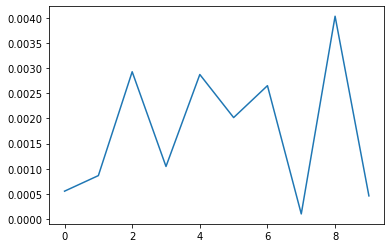

prediction : (10000,)
true label : (10000,)


array([[ 975,    0,    0,    1,    0,    1,    0,    1,    1,    1],
       [   0, 1126,    1,    1,    0,    1,    2,    1,    3,    0],
       [   6,    1, 1009,    2,    1,    0,    4,    4,    5,    0],
       [   0,    0,    1,  994,    0,    4,    0,    2,    4,    5],
       [   0,    0,    3,    1,  962,    2,    2,    2,    0,   10],
       [   3,    0,    0,    7,    1,  870,    4,    1,    3,    3],
       [   3,    2,    0,    1,    3,    3,  943,    0,    3,    0],
       [   0,    1,    7,    2,    1,    0,    0, 1008,    2,    7],
       [   2,    0,    3,    3,    2,    5,    1,    3,  952,    3],
       [   1,    2,    0,    6,    8,    2,    0,    6,    4,  980]])

In [24]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

torch.Size([10000, 784]) torch.Size([10000, 1024]) torch.Size([10000, 1024]) torch.Size([10000, 300]) torch.Size([10000, 300])


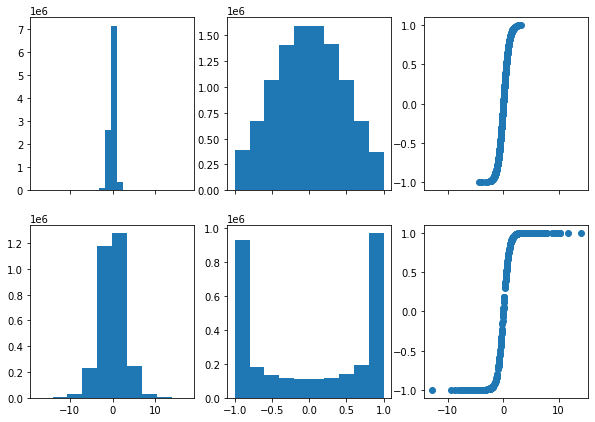

In [25]:
print(x.shape, output1.shape, hidden1.shape, output2.shape, hidden2.shape)

def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')
    axs[0, 0].hist(o1.reshape(-1))
    axs[0, 1].hist(h1.reshape(-1))
    axs[0, 2].scatter(o1[0], h1[0])
    axs[1, 0].hist(o2.reshape(-1))
    axs[1, 1].hist(h2.reshape(-1))
    axs[1, 2].scatter(o2[0], h2[0])
    plt.show()
plot_inner_dist(x.cpu().numpy(), output1.cpu().numpy(), 
                hidden1.cpu().numpy(), output2.cpu().numpy(), hidden2.cpu().numpy())

In [26]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)

        output2 = self.fc2(hidden1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        
        logit = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [27]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())

    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.06398878246545792
5 epoch loss: 0.00494967820122838
total 10000
correct tensor(9803.)
accuracy tensor(0.9803)


In [32]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        self.drop2 = nn.Dropout(dropout_rate) # 드롭아웃은 엑티베이션 함수 뒤에 두줄
        
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)
        drop1 = self.drop1(hidden1)

        output2 = self.fc2(drop1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        drop2 = self.drop2(hidden2)
        
        logit = self.fc3(drop2)
        
        return logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [33]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())

    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

ValueError: too many values to unpack (expected 5)

In [40]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10
        
        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        self.drop2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(self.hidden2, self.final)
        
    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)
        drop1 = self.drop1(hidden1)

        output2 = self.fc2(drop1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        drop2 = self.drop2(hidden2)
        
        logit = self.fc3(drop2)
        
        return logit

model = MLP().to(device)
model.train()

#
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    

AttributeError: module 'torch.optim' has no attribute 'ADAM'

In [39]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())

    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

ValueError: too many values to unpack (expected 5)